# Kinyarwanda Teaching Chatbot - Train from Scratch

This notebook trains a Kinyarwanda teaching chatbot completely from scratch using only the dataset, without any pretrained models.

## Approach
- Build vocabulary from the dataset
- Train word embeddings from scratch
- Create a neural network model for question-answer matching
- Implement a teaching chatbot interface

## Dataset Structure
- instruction: English questions about Kinyarwanda
- output: Kinyarwanda responses with English explanations
- category: conversation, vocabulary, grammar
- difficulty_level: beginner, intermediate, advanced


In [41]:
# Import necessary libraries
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")


Libraries imported successfully!
PyTorch version: 2.7.0
Device: CPU


## 1. Load and Explore Dataset


In [42]:
# Load the dataset
dataset_path = '../datasets/kinyarwanda_dataset_final.jsonl'
data = []

with open(dataset_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line.strip()))

print(f"Loaded {len(data)} examples from the dataset")

# Convert to DataFrame for easier analysis
df = pd.DataFrame(data)
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

# Display first few examples
print("\nFirst 3 examples:")
for i in range(min(3, len(data))):
    print(f"\nExample {i+1}:")
    print(f"Instruction: {data[i]['instruction']}")
    print(f"Output: {data[i]['output']}")
    print(f"Category: {data[i]['category']}")
    print(f"Difficulty: {data[i]['difficulty_level']}")


Loaded 510 examples from the dataset

Dataset shape: (510, 8)

Columns: ['instruction', 'input', 'output', 'category', 'lesson_reference', 'difficulty_level', 'tags', 'source']

First 3 examples:

Example 1:
Instruction: How do you say 'Good morning' in Kinyarwanda?
Output: Mwaramutseho (used until noon for someone you see nearly every day).
Category: conversation
Difficulty: beginner

Example 2:
Instruction: How do you say 'Hello' in the afternoon in Kinyarwanda?
Output: Mwiriweho or Mwiriwe (used from noon on).
Category: conversation
Difficulty: beginner

Example 3:
Instruction: How do you greet someone you haven't seen for a long time in Kinyarwanda?
Output: Muraho? (Hello, to someone you see rarely or haven't seen for a long time).
Category: conversation
Difficulty: beginner


Dataset Statistics:
Total examples: 510

Categories:
NaN             257
conversation    138
vocabulary       75
translation      18
grammar          14
quiz              3
culture           3
dialogue          2
Name: category, dtype: int64
Missing category entries: 257

Difficulty levels:
NaN             257
beginner        132
advanced         73
intermediate     48
Name: difficulty_level, dtype: int64
Missing difficulty_level entries: 257

Text length statistics:
Instruction length - Mean: 56.8, Max: 104
Output length - Mean: 68.7, Max: 205


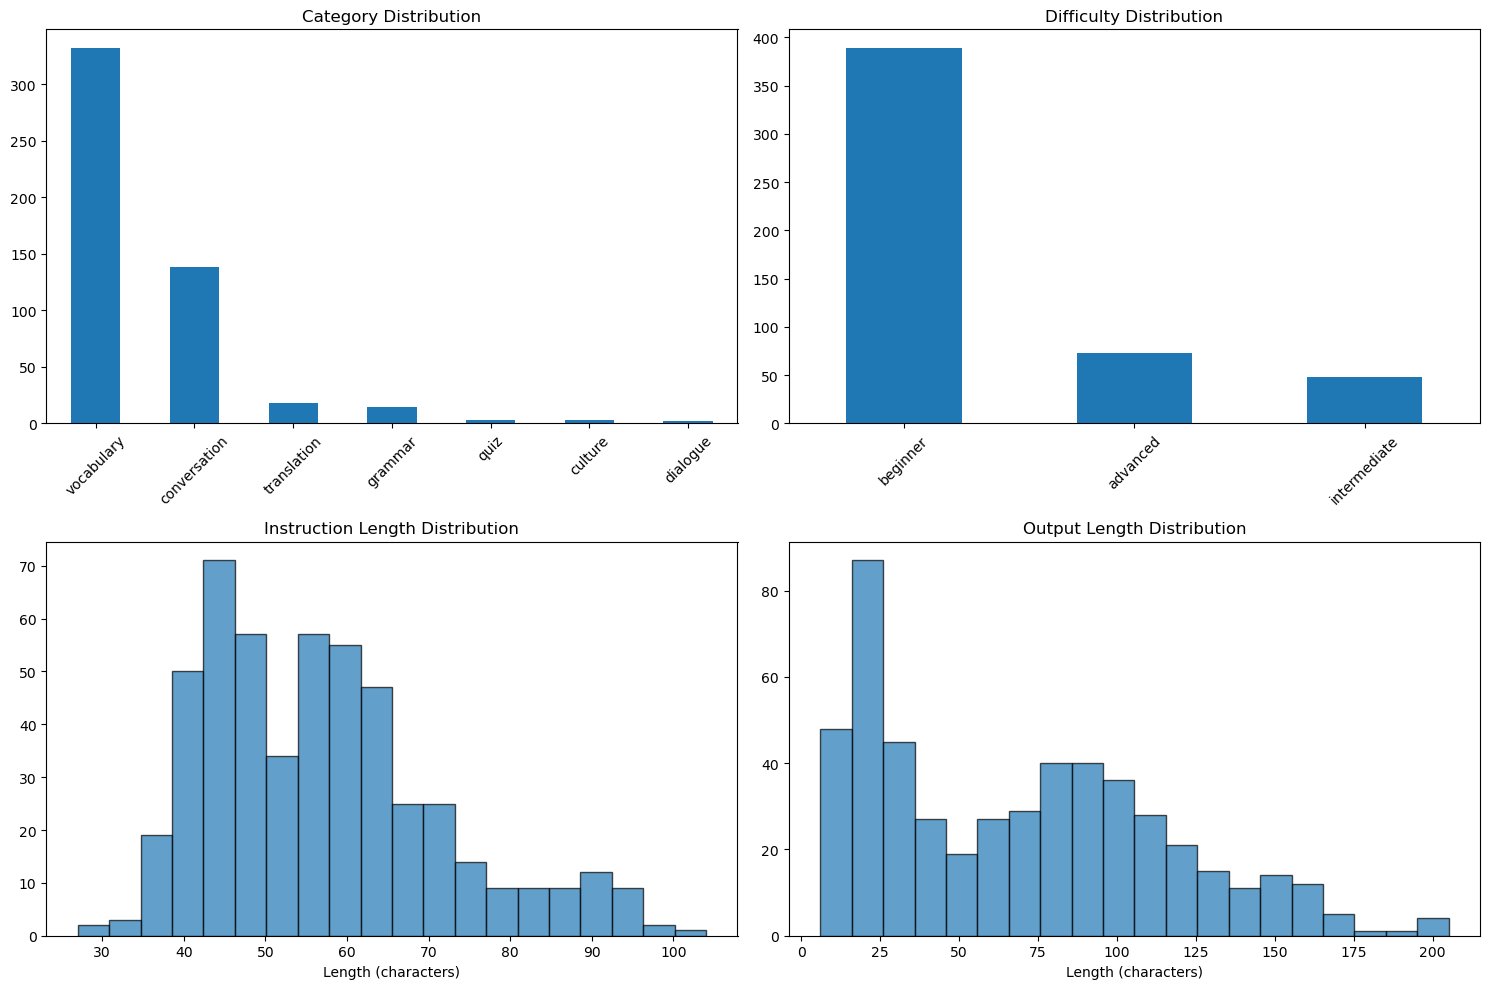

In [43]:
# Analyze dataset statistics
print("Dataset Statistics:")
print(f"Total examples: {len(df)}")

# Handle missing fields in analysis
print(f"\nCategories:")
if 'category' in df.columns:
    category_counts = df['category'].value_counts(dropna=False)
    print(category_counts)
    missing_categories = df['category'].isna().sum()
    if missing_categories > 0:
        print(f"Missing category entries: {missing_categories}")
else:
    print("No category field found")

print(f"\nDifficulty levels:")
if 'difficulty_level' in df.columns:
    difficulty_counts = df['difficulty_level'].value_counts(dropna=False)
    print(difficulty_counts)
    missing_difficulties = df['difficulty_level'].isna().sum()
    if missing_difficulties > 0:
        print(f"Missing difficulty_level entries: {missing_difficulties}")
else:
    print("No difficulty_level field found")

# Analyze text lengths
df['instruction_length'] = df['instruction'].str.len()
df['output_length'] = df['output'].str.len()

print(f"\nText length statistics:")
print(f"Instruction length - Mean: {df['instruction_length'].mean():.1f}, Max: {df['instruction_length'].max()}")
print(f"Output length - Mean: {df['output_length'].mean():.1f}, Max: {df['output_length'].max()}")

# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Category distribution
if 'category' in df.columns:
    # Fill missing values with 'vocabulary' (default)
    df['category'] = df['category'].fillna('vocabulary')
    df['category'].value_counts().plot(kind='bar', ax=axes[0,0], title='Category Distribution')
    axes[0,0].tick_params(axis='x', rotation=45)
else:
    axes[0,0].text(0.5, 0.5, 'No category data', ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,0].set_title('Category Distribution')

# Difficulty distribution
if 'difficulty_level' in df.columns:
    # Fill missing values with 'beginner' (default)
    df['difficulty_level'] = df['difficulty_level'].fillna('beginner')
    df['difficulty_level'].value_counts().plot(kind='bar', ax=axes[0,1], title='Difficulty Distribution')
    axes[0,1].tick_params(axis='x', rotation=45)
else:
    axes[0,1].text(0.5, 0.5, 'No difficulty data', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Difficulty Distribution')

# Instruction length distribution
axes[1,0].hist(df['instruction_length'], bins=20, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Instruction Length Distribution')
axes[1,0].set_xlabel('Length (characters)')

# Output length distribution
axes[1,1].hist(df['output_length'], bins=20, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Output Length Distribution')
axes[1,1].set_xlabel('Length (characters)')

plt.tight_layout()
plt.show()


## 2. Text Preprocessing and Vocabulary Building


In [44]:
class TextPreprocessor:
    def __init__(self):
        self.vocab = {'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3}
        self.reverse_vocab = {0: '<PAD>', 1: '<UNK>', 2: '<START>', 3: '<END>'}
        self.vocab_size = 4
        self.word_counts = Counter()
        
    def clean_text(self, text):
        """Clean and normalize text"""
        # Convert to lowercase
        text = text.lower()
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        # Remove punctuation but keep apostrophes
        text = re.sub(r'[^\w\s\']', '', text)
        return text.strip()
    
    def tokenize(self, text):
        """Simple tokenization"""
        return self.clean_text(text).split()
    
    def build_vocabulary(self, texts, min_freq=2):
        """Build vocabulary from texts"""
        print("Building vocabulary...")
        
        # Count all words
        for text in texts:
            tokens = self.tokenize(text)
            self.word_counts.update(tokens)
        
        # Add words that appear at least min_freq times
        for word, count in self.word_counts.items():
            if count >= min_freq:
                self.vocab[word] = self.vocab_size
                self.reverse_vocab[self.vocab_size] = word
                self.vocab_size += 1
        
        print(f"Built vocabulary with {self.vocab_size} words")
        print(f"Most common words: {self.word_counts.most_common(10)}")
        
    def text_to_sequence(self, text, max_length=100):
        """Convert text to sequence of word indices"""
        tokens = self.tokenize(text)
        sequence = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        
        # Pad or truncate to max_length
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence.extend([self.vocab['<PAD>']] * (max_length - len(sequence)))
        
        return sequence
    
    def sequence_to_text(self, sequence):
        """Convert sequence of indices back to text"""
        words = [self.reverse_vocab.get(idx, '<UNK>') for idx in sequence]
        # Remove padding tokens
        words = [word for word in words if word != '<PAD>']
        return ' '.join(words)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Collect all texts for vocabulary building
all_texts = []
for item in data:
    all_texts.append(item['instruction'])
    all_texts.append(item['output'])

# Build vocabulary
preprocessor.build_vocabulary(all_texts, min_freq=2)

print(f"\nVocabulary size: {preprocessor.vocab_size}")


Building vocabulary...
Built vocabulary with 757 words
Most common words: [('the', 549), ('in', 464), ('kinyarwanda', 448), ('you', 399), ('do', 318), ('how', 312), ('example', 237), ('is', 219), ('for', 191), ('to', 182)]

Vocabulary size: 757


## 3. Dataset Preparation


In [45]:
class KinyarwandaDataset(Dataset):
    def __init__(self, data, preprocessor, max_length=100):
        self.data = data
        self.preprocessor = preprocessor
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Convert texts to sequences
        instruction_seq = self.preprocessor.text_to_sequence(item['instruction'], self.max_length)
        output_seq = self.preprocessor.text_to_sequence(item['output'], self.max_length)
        
        # Create labels for categories and difficulty with default values for missing fields
        category_mapping = {'conversation': 0, 'vocabulary': 1, 'grammar': 2}
        difficulty_mapping = {'beginner': 0, 'intermediate': 1, 'advanced': 2}
        
        # Handle missing category field - default to 'vocabulary' (label 1)
        category = item.get('category', 'vocabulary')
        category_label = category_mapping.get(category, 1)
        
        # Handle missing difficulty_level field - default to 'beginner' (label 0)
        difficulty = item.get('difficulty_level', 'beginner')
        difficulty_label = difficulty_mapping.get(difficulty, 0)
        
        return {
            'instruction': torch.tensor(instruction_seq, dtype=torch.long),
            'output': torch.tensor(output_seq, dtype=torch.long),
            'category': torch.tensor(category_label, dtype=torch.long),
            'difficulty': torch.tensor(difficulty_label, dtype=torch.long),
            'instruction_text': item['instruction'],
            'output_text': item['output']
        }

# Split data into train/validation/test
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Dataset splits:")
print(f"Train: {len(train_data)} examples")
print(f"Validation: {len(val_data)} examples")
print(f"Test: {len(test_data)} examples")

# Create datasets
train_dataset = KinyarwandaDataset(train_data, preprocessor)
val_dataset = KinyarwandaDataset(val_data, preprocessor)
test_dataset = KinyarwandaDataset(test_data, preprocessor)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nData loaders created with batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Dataset splits:
Train: 357 examples
Validation: 76 examples
Test: 77 examples

Data loaders created with batch size: 16
Training batches: 23
Validation batches: 5
Test batches: 5


## 4. Model Architecture


In [46]:
class KinyarwandaTeachingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2):
        super(KinyarwandaTeachingModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Encoder for instruction (question)
        self.instruction_encoder = nn.LSTM(
            embedding_dim, hidden_dim, num_layers, 
            batch_first=True, dropout=0.2, bidirectional=True
        )
        
        # Encoder for output (answer)
        self.output_encoder = nn.LSTM(
            embedding_dim, hidden_dim, num_layers,
            batch_first=True, dropout=0.2, bidirectional=True
        )
        
        # Projection layers
        self.instruction_projection = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output_projection = nn.Linear(hidden_dim * 2, hidden_dim)
        
        # Similarity computation
        self.similarity_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
        # Classification heads
        self.category_classifier = nn.Linear(hidden_dim, 3)  # 3 categories
        self.difficulty_classifier = nn.Linear(hidden_dim, 3)  # 3 difficulty levels
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def encode_sequence(self, sequence, encoder, projection):
        """Encode a sequence using the specified encoder"""
        # Embedding
        embedded = self.embedding(sequence)
        
        # LSTM encoding
        output, (hidden, cell) = encoder(embedded)
        
        # Use the last hidden state (concatenate forward and backward)
        if encoder.bidirectional:
            # Concatenate forward and backward hidden states
            final_hidden = torch.cat([hidden[-2], hidden[-1]], dim=-1)
        else:
            final_hidden = hidden[-1]
        
        # Project to common dimension
        projected = projection(final_hidden)
        
        return projected
    
    def forward(self, instruction, output):
        """Forward pass"""
        # Encode instruction and output
        instruction_repr = self.encode_sequence(
            instruction, self.instruction_encoder, self.instruction_projection
        )
        output_repr = self.encode_sequence(
            output, self.output_encoder, self.output_projection
        )
        
        # Compute similarity
        combined = torch.cat([instruction_repr, output_repr], dim=-1)
        similarity = self.similarity_head(combined)
        
        # Classify category and difficulty based on instruction
        category_logits = self.category_classifier(instruction_repr)
        difficulty_logits = self.difficulty_classifier(instruction_repr)
        
        return {
            'similarity': similarity,
            'category_logits': category_logits,
            'difficulty_logits': difficulty_logits,
            'instruction_repr': instruction_repr,
            'output_repr': output_repr
        }
    
    def encode_instruction(self, instruction):
        """Encode only the instruction for inference"""
        return self.encode_sequence(
            instruction, self.instruction_encoder, self.instruction_projection
        )
    
    def encode_output(self, output):
        """Encode only the output for inference"""
        return self.encode_sequence(
            output, self.output_encoder, self.output_projection
        )

# Initialize model with increased capacity for better learning
model = KinyarwandaTeachingModel(
    vocab_size=preprocessor.vocab_size,
    embedding_dim=256,  # Increased from 128
    hidden_dim=512,     # Increased from 256
    num_layers=3        # Increased from 2
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB")


Model created successfully!
Total parameters: 33,278,215
Trainable parameters: 33,278,215
Model size: 126.95 MB


## 5. Training Setup


In [47]:
# Training configuration - Use Apple Silicon GPU (MPS) if available
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

model.to(device)

# Loss functions
similarity_criterion = nn.BCELoss()
category_criterion = nn.CrossEntropyLoss()
difficulty_criterion = nn.CrossEntropyLoss()

# Optimizer with better learning rate for from-scratch training
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# Training parameters with early stopping
num_epochs = 100  # Maximum epochs
print_every = 10
save_every = 20

# Early stopping parameters
early_stopping_patience = 40  # Stop if no improvement for 20 epochs
min_delta = 0.001  # Minimum change to qualify as improvement

# Training history - expanded metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_category_f1 = []
val_category_f1 = []
train_difficulty_f1 = []
val_difficulty_f1 = []
train_similarity_scores = []
val_similarity_scores = []

print(f"Training configuration:")
print(f"Device: {device}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Model capacity: Increased for better learning from scratch")
print(f"Training approach: Contrastive learning with negative sampling")


Using Apple Silicon GPU (MPS)
Training configuration:
Device: mps
Learning rate: 0.003
Epochs: 100
Batch size: 16
Model capacity: Increased for better learning from scratch
Training approach: Contrastive learning with negative sampling


## 6. Training Functions


In [48]:
def train_epoch(model, train_loader, optimizer, device):
    """Train for one epoch with improved contrastive learning and comprehensive metrics"""
    model.train()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0
    
    # For detailed metrics
    all_category_predictions = []
    all_category_labels = []
    all_difficulty_predictions = []
    all_difficulty_labels = []
    all_similarity_scores = []
    
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch in progress_bar:
        # Move to device
        instruction = batch['instruction'].to(device)
        output = batch['output'].to(device)
        category = batch['category'].to(device)
        difficulty = batch['difficulty'].to(device)
        
        batch_size = instruction.size(0)
        
        # Forward pass
        optimizer.zero_grad()
        results = model(instruction, output)
        
        # Positive pairs similarity (current instruction-output pairs)
        similarity_targets = torch.ones(batch_size, 1).to(device)
        similarity_loss = similarity_criterion(results['similarity'], similarity_targets)
        
        # Negative sampling: pair instructions with wrong outputs
        if batch_size > 1:
            # Create negative pairs by shuffling outputs
            shuffled_indices = torch.randperm(batch_size).to(device)
            negative_output = output[shuffled_indices]
            
            # Make sure we don't accidentally get positive pairs
            mask = shuffled_indices != torch.arange(batch_size).to(device)
            if mask.any():
                neg_results = model(instruction[mask], negative_output[mask])
                neg_targets = torch.zeros(neg_results['similarity'].size(0), 1).to(device)
                negative_loss = similarity_criterion(neg_results['similarity'], neg_targets)
                similarity_loss = similarity_loss + negative_loss
        
        # Classification losses
        category_loss = category_criterion(results['category_logits'], category)
        difficulty_loss = difficulty_criterion(results['difficulty_logits'], difficulty)
        
        # Combined loss with higher weight on similarity
        total_loss_batch = 2.0 * similarity_loss + 0.5 * category_loss + 0.5 * difficulty_loss
        
        # Backward pass
        total_loss_batch.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Statistics
        total_loss += total_loss_batch.item()
        total_samples += batch_size
        
        # Calculate accuracy for category prediction
        _, predicted_categories = torch.max(results['category_logits'], 1)
        correct_predictions += (predicted_categories == category).sum().item()
        
        # Collect predictions for detailed metrics
        all_category_predictions.extend(predicted_categories.cpu().numpy())
        all_category_labels.extend(category.cpu().numpy())
        
        _, predicted_difficulties = torch.max(results['difficulty_logits'], 1)
        all_difficulty_predictions.extend(predicted_difficulties.cpu().numpy())
        all_difficulty_labels.extend(difficulty.cpu().numpy())
        
        # Collect similarity scores
        all_similarity_scores.extend(results['similarity'].detach().cpu().numpy().flatten())
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': total_loss_batch.item(),
            'avg_loss': total_loss / len(progress_bar)
        })
    
    # Calculate comprehensive metrics
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    
    # Calculate F1 scores
    from sklearn.metrics import f1_score
    category_f1 = f1_score(all_category_labels, all_category_predictions, average='weighted')
    difficulty_f1 = f1_score(all_difficulty_labels, all_difficulty_predictions, average='weighted')
    
    # Calculate average similarity score
    avg_similarity = np.mean(all_similarity_scores)
    
    return avg_loss, accuracy, category_f1, difficulty_f1, avg_similarity

def validate_epoch(model, val_loader, device):
    """Validate for one epoch with comprehensive metrics"""
    model.eval()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0
    
    # For detailed metrics
    all_category_predictions = []
    all_category_labels = []
    all_difficulty_predictions = []
    all_difficulty_labels = []
    all_similarity_scores = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation')
        
        for batch in progress_bar:
            # Move to device
            instruction = batch['instruction'].to(device)
            output = batch['output'].to(device)
            category = batch['category'].to(device)
            difficulty = batch['difficulty'].to(device)
            
            # Forward pass
            results = model(instruction, output)
            
            # Create similarity targets
            similarity_targets = torch.ones(instruction.size(0), 1).to(device)
            
            # Calculate losses
            similarity_loss = similarity_criterion(results['similarity'], similarity_targets)
            category_loss = category_criterion(results['category_logits'], category)
            difficulty_loss = difficulty_criterion(results['difficulty_logits'], difficulty)
            
            # Combined loss
            total_loss_batch = similarity_loss + 0.3 * category_loss + 0.3 * difficulty_loss
            
            # Statistics
            total_loss += total_loss_batch.item()
            total_samples += instruction.size(0)
            
            # Calculate accuracy
            _, predicted_categories = torch.max(results['category_logits'], 1)
            correct_predictions += (predicted_categories == category).sum().item()
            
            # Collect predictions for detailed metrics
            all_category_predictions.extend(predicted_categories.cpu().numpy())
            all_category_labels.extend(category.cpu().numpy())
            
            _, predicted_difficulties = torch.max(results['difficulty_logits'], 1)
            all_difficulty_predictions.extend(predicted_difficulties.cpu().numpy())
            all_difficulty_labels.extend(difficulty.cpu().numpy())
            
            # Collect similarity scores
            all_similarity_scores.extend(results['similarity'].detach().cpu().numpy().flatten())
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': total_loss_batch.item(),
                'avg_loss': total_loss / len(progress_bar)
            })
    
    # Calculate comprehensive metrics
    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples
    
    # Calculate F1 scores
    from sklearn.metrics import f1_score
    category_f1 = f1_score(all_category_labels, all_category_predictions, average='weighted')
    difficulty_f1 = f1_score(all_difficulty_labels, all_difficulty_predictions, average='weighted')
    
    # Calculate average similarity score
    avg_similarity = np.mean(all_similarity_scores)
    
    return avg_loss, accuracy, category_f1, difficulty_f1, avg_similarity

print("Training functions defined successfully!")


Training functions defined successfully!


## 7. Model Training


In [49]:
# Training loop with early stopping and comprehensive metrics
print("Starting training with early stopping...")
best_val_score = -float('inf')  # Using composite score (higher is better)
best_model_state = None
epochs_without_improvement = 0

# Track best individual metrics
best_metrics = {
    'loss': float('inf'),
    'accuracy': 0.0,
    'category_f1': 0.0,
    'difficulty_f1': 0.0,
    'similarity': 0.0
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 70)
    
    # Training
    train_loss, train_acc, train_cat_f1, train_diff_f1, train_sim = train_epoch(model, train_loader, optimizer, device)
    
    # Validation
    val_loss, val_acc, val_cat_f1, val_diff_f1, val_sim = validate_epoch(model, val_loader, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_category_f1.append(train_cat_f1)
    val_category_f1.append(val_cat_f1)
    train_difficulty_f1.append(train_diff_f1)
    val_difficulty_f1.append(val_diff_f1)
    train_similarity_scores.append(train_sim)
    val_similarity_scores.append(val_sim)
    
    # Print comprehensive results
    print(f"📊 Training   - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Cat-F1: {train_cat_f1:.4f}, Diff-F1: {train_diff_f1:.4f}, Sim: {train_sim:.4f}")
    print(f"📊 Validation - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Cat-F1: {val_cat_f1:.4f}, Diff-F1: {val_diff_f1:.4f}, Sim: {val_sim:.4f}")
    print(f"📈 Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Calculate composite score (weighted combination of metrics)
    # Higher is better: accuracy + f1_scores + similarity - normalized_loss
    normalized_loss = 1.0 / (1.0 + val_loss)  # Convert loss to 0-1 scale (higher is better)
    composite_score = (
        0.3 * val_acc +           # 30% accuracy
        0.2 * val_cat_f1 +        # 20% category F1
        0.2 * val_diff_f1 +       # 20% difficulty F1
        0.2 * val_sim +           # 20% similarity
        0.1 * normalized_loss     # 10% normalized loss
    )
    
    # Track best metrics
    improved = False
    if val_loss < best_metrics['loss']:
        best_metrics['loss'] = val_loss
        improved = True
    if val_acc > best_metrics['accuracy']:
        best_metrics['accuracy'] = val_acc
        improved = True
    if val_cat_f1 > best_metrics['category_f1']:
        best_metrics['category_f1'] = val_cat_f1
        improved = True
    if val_diff_f1 > best_metrics['difficulty_f1']:
        best_metrics['difficulty_f1'] = val_diff_f1
        improved = True
    if val_sim > best_metrics['similarity']:
        best_metrics['similarity'] = val_sim
        improved = True
    
    # Early stopping based on composite score
    if composite_score > best_val_score + min_delta:
        best_val_score = composite_score
        best_model_state = model.state_dict().copy()
        epochs_without_improvement = 0
        print(f"✅ New best model saved! Composite Score: {composite_score:.4f}")
    else:
        epochs_without_improvement += 1
        print(f"⏳ No improvement for {epochs_without_improvement} epochs (Best: {best_val_score:.4f})")
    
    # Save checkpoint
    if (epoch + 1) % save_every == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_metrics': {
                'loss': train_loss, 'accuracy': train_acc, 
                'category_f1': train_cat_f1, 'difficulty_f1': train_diff_f1, 
                'similarity': train_sim
            },
            'val_metrics': {
                'loss': val_loss, 'accuracy': val_acc,
                'category_f1': val_cat_f1, 'difficulty_f1': val_diff_f1, 
                'similarity': val_sim
            },
            'composite_score': composite_score,
            'best_metrics': best_metrics,
            'preprocessor': preprocessor
        }
        torch.save(checkpoint, f'kinyarwanda_model_epoch_{epoch + 1}.pt')
        print(f"💾 Checkpoint saved at epoch {epoch + 1}")
    
    # Early stopping
    if epochs_without_improvement >= early_stopping_patience:
        print(f"\n🛑 Early stopping triggered after {epochs_without_improvement} epochs without improvement")
        break

print("\n🎉 Training completed!")
print(f"📊 Best composite score: {best_val_score:.4f}")
print(f"🏆 Best individual metrics:")
for metric, value in best_metrics.items():
    print(f"   • {metric.replace('_', ' ').title()}: {value:.4f}")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("✅ Best model loaded based on composite score")


Starting training with early stopping...

Epoch 1/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.85it/s, loss=0.396, avg_loss=0.44] 


📊 Training   - Loss: 7.4618, Acc: 0.7143, Cat-F1: 0.7103, Diff-F1: 0.7696, Sim: 0.5523
📊 Validation - Loss: 0.4398, Acc: 0.8816, Cat-F1: 0.8524, Diff-F1: 0.8516, Sim: 0.8761
📈 Learning Rate: 0.003000
✅ New best model saved! Composite Score: 0.8499

Epoch 2/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.63it/s, loss=0.335, avg_loss=0.435]


📊 Training   - Loss: 4.5961, Acc: 0.8179, Cat-F1: 0.8297, Diff-F1: 0.8271, Sim: 0.5434
📊 Validation - Loss: 0.4345, Acc: 0.8816, Cat-F1: 0.8524, Diff-F1: 0.8521, Sim: 0.9508
📈 Learning Rate: 0.003000
✅ New best model saved! Composite Score: 0.8652

Epoch 3/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.39it/s, loss=0.855, avg_loss=0.831]


📊 Training   - Loss: 5.6645, Acc: 0.7339, Cat-F1: 0.8009, Diff-F1: 0.8025, Sim: 0.7689
📊 Validation - Loss: 0.8311, Acc: 0.8684, Cat-F1: 0.8423, Diff-F1: 0.8319, Sim: 0.7310
📈 Learning Rate: 0.003000
⏳ No improvement for 1 epochs (Best: 0.8652)

Epoch 4/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s, loss=1.96, avg_loss=1.95] 


📊 Training   - Loss: 4.0766, Acc: 0.8908, Cat-F1: 0.8797, Diff-F1: 0.7794, Sim: 0.5320
📊 Validation - Loss: 1.9476, Acc: 0.8816, Cat-F1: 0.8524, Diff-F1: 0.8521, Sim: 0.1868
📈 Learning Rate: 0.003000
⏳ No improvement for 2 epochs (Best: 0.8652)

Epoch 5/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.35it/s, loss=1.29, avg_loss=1.35] 


📊 Training   - Loss: 3.9576, Acc: 0.8908, Cat-F1: 0.8781, Diff-F1: 0.8365, Sim: 0.5547
📊 Validation - Loss: 1.3530, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.3853
📈 Learning Rate: 0.003000
⏳ No improvement for 3 epochs (Best: 0.8652)

Epoch 6/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.37it/s, loss=0.513, avg_loss=0.645]


📊 Training   - Loss: 3.8141, Acc: 0.8319, Cat-F1: 0.8235, Diff-F1: 0.8205, Sim: 0.5757
📊 Validation - Loss: 0.6447, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.8455
📈 Learning Rate: 0.003000
⏳ No improvement for 4 epochs (Best: 0.8652)

Epoch 7/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.41it/s, loss=3.34, avg_loss=3.27]


📊 Training   - Loss: 4.9563, Acc: 0.8403, Cat-F1: 0.8293, Diff-F1: 0.7318, Sim: 0.6215
📊 Validation - Loss: 3.2672, Acc: 0.8947, Cat-F1: 0.8674, Diff-F1: 0.8516, Sim: 0.0642
📈 Learning Rate: 0.003000
⏳ No improvement for 5 epochs (Best: 0.8652)

Epoch 8/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.33it/s, loss=2.02, avg_loss=2.18]


📊 Training   - Loss: 4.3922, Acc: 0.8824, Cat-F1: 0.8748, Diff-F1: 0.7979, Sim: 0.5781
📊 Validation - Loss: 2.1754, Acc: 0.7632, Cat-F1: 0.7082, Diff-F1: 0.7830, Sim: 0.4998
📈 Learning Rate: 0.003000
⏳ No improvement for 6 epochs (Best: 0.8652)

Epoch 9/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s, loss=0.827, avg_loss=1.22]


📊 Training   - Loss: 25.9138, Acc: 0.7255, Cat-F1: 0.7427, Diff-F1: 0.6939, Sim: 0.7342
📊 Validation - Loss: 1.2216, Acc: 0.8553, Cat-F1: 0.8340, Diff-F1: 0.7819, Sim: 0.5473
📈 Learning Rate: 0.003000
⏳ No improvement for 7 epochs (Best: 0.8652)

Epoch 10/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.41it/s, loss=2.27, avg_loss=2.24]


📊 Training   - Loss: 3.4879, Acc: 0.8487, Cat-F1: 0.8406, Diff-F1: 0.7986, Sim: 0.5011
📊 Validation - Loss: 2.2364, Acc: 0.4474, Cat-F1: 0.4574, Diff-F1: 0.4139, Sim: 0.5948
📈 Learning Rate: 0.003000
⏳ No improvement for 8 epochs (Best: 0.8652)

Epoch 11/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s, loss=0.785, avg_loss=0.809]


📊 Training   - Loss: 4.1262, Acc: 0.7955, Cat-F1: 0.7887, Diff-F1: 0.7692, Sim: 0.4860
📊 Validation - Loss: 0.8093, Acc: 0.8684, Cat-F1: 0.8366, Diff-F1: 0.8516, Sim: 0.5606
📈 Learning Rate: 0.003000
⏳ No improvement for 9 epochs (Best: 0.8652)

Epoch 12/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.25it/s, loss=0.535, avg_loss=0.477]


📊 Training   - Loss: 4.6148, Acc: 0.8067, Cat-F1: 0.7996, Diff-F1: 0.8505, Sim: 0.6586
📊 Validation - Loss: 0.4773, Acc: 0.8553, Cat-F1: 0.8340, Diff-F1: 0.8407, Sim: 0.9844
📈 Learning Rate: 0.003000
⏳ No improvement for 10 epochs (Best: 0.8652)

Epoch 13/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.21it/s, loss=12.2, avg_loss=12.5]


📊 Training   - Loss: 5.8145, Acc: 0.7647, Cat-F1: 0.7536, Diff-F1: 0.7307, Sim: 0.7672
📊 Validation - Loss: 12.4970, Acc: 0.1842, Cat-F1: 0.0573, Diff-F1: 0.7330, Sim: 0.0000
📈 Learning Rate: 0.001500
⏳ No improvement for 11 epochs (Best: 0.8652)

Epoch 14/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.37it/s, loss=0.348, avg_loss=0.585]


📊 Training   - Loss: 6.4569, Acc: 0.5238, Cat-F1: 0.5366, Diff-F1: 0.6369, Sim: 0.7057
📊 Validation - Loss: 0.5851, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.9815
📈 Learning Rate: 0.001500
⏳ No improvement for 12 epochs (Best: 0.8652)

Epoch 15/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.21it/s, loss=0.52, avg_loss=0.626] 


📊 Training   - Loss: 5.2027, Acc: 0.5602, Cat-F1: 0.5476, Diff-F1: 0.6438, Sim: 0.5579
📊 Validation - Loss: 0.6259, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.0155, Sim: 0.9969
📈 Learning Rate: 0.001500
⏳ No improvement for 13 epochs (Best: 0.8652)

Epoch 16/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s, loss=0.393, avg_loss=0.557]


📊 Training   - Loss: 4.8517, Acc: 0.6723, Cat-F1: 0.5747, Diff-F1: 0.6155, Sim: 0.7362
📊 Validation - Loss: 0.5569, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.8730
📈 Learning Rate: 0.001500
⏳ No improvement for 14 epochs (Best: 0.8652)

Epoch 17/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.33it/s, loss=0.431, avg_loss=0.518]


📊 Training   - Loss: 4.1438, Acc: 0.6835, Cat-F1: 0.6093, Diff-F1: 0.6438, Sim: 0.9091
📊 Validation - Loss: 0.5184, Acc: 0.8816, Cat-F1: 0.8590, Diff-F1: 0.7330, Sim: 0.9557
📈 Learning Rate: 0.001500
⏳ No improvement for 15 epochs (Best: 0.8652)

Epoch 18/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.15it/s, loss=0.606, avg_loss=0.655]


📊 Training   - Loss: 3.9886, Acc: 0.6975, Cat-F1: 0.5891, Diff-F1: 0.6438, Sim: 0.6839
📊 Validation - Loss: 0.6551, Acc: 0.6842, Cat-F1: 0.6911, Diff-F1: 0.0155, Sim: 0.9942
📈 Learning Rate: 0.001500
⏳ No improvement for 16 epochs (Best: 0.8652)

Epoch 19/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.37it/s, loss=0.515, avg_loss=0.567]


📊 Training   - Loss: 3.8131, Acc: 0.7619, Cat-F1: 0.7529, Diff-F1: 0.5954, Sim: 0.8164
📊 Validation - Loss: 0.5671, Acc: 0.8816, Cat-F1: 0.8590, Diff-F1: 0.8425, Sim: 0.7876
📈 Learning Rate: 0.001500
⏳ No improvement for 17 epochs (Best: 0.8652)

Epoch 20/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.04it/s, loss=0.301, avg_loss=0.429]


📊 Training   - Loss: 3.9960, Acc: 0.8908, Cat-F1: 0.8800, Diff-F1: 0.7753, Sim: 0.8798
📊 Validation - Loss: 0.4288, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.9021
📈 Learning Rate: 0.001500
⏳ No improvement for 18 epochs (Best: 0.8652)
💾 Checkpoint saved at epoch 20

Epoch 21/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s, loss=1.42, avg_loss=1.48] 


📊 Training   - Loss: 4.1581, Acc: 0.8796, Cat-F1: 0.8664, Diff-F1: 0.8206, Sim: 0.6509
📊 Validation - Loss: 1.4754, Acc: 0.9079, Cat-F1: 0.8828, Diff-F1: 0.8425, Sim: 0.3118
📈 Learning Rate: 0.001500
⏳ No improvement for 19 epochs (Best: 0.8652)

Epoch 22/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.21it/s, loss=0.29, avg_loss=0.344] 


📊 Training   - Loss: 2.3771, Acc: 0.8711, Cat-F1: 0.8595, Diff-F1: 0.8469, Sim: 0.6235
📊 Validation - Loss: 0.3436, Acc: 0.8816, Cat-F1: 0.8547, Diff-F1: 0.8425, Sim: 0.9188
📈 Learning Rate: 0.001500
⏳ No improvement for 20 epochs (Best: 0.8652)

Epoch 23/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s, loss=0.497, avg_loss=0.492]


📊 Training   - Loss: 4.2420, Acc: 0.8852, Cat-F1: 0.8743, Diff-F1: 0.8227, Sim: 0.8583
📊 Validation - Loss: 0.4920, Acc: 0.8816, Cat-F1: 0.8524, Diff-F1: 0.7830, Sim: 0.8368
📈 Learning Rate: 0.001500
⏳ No improvement for 21 epochs (Best: 0.8652)

Epoch 24/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.04it/s, loss=0.406, avg_loss=0.556]


📊 Training   - Loss: 2.6197, Acc: 0.9020, Cat-F1: 0.8906, Diff-F1: 0.8175, Sim: 0.8851
📊 Validation - Loss: 0.5564, Acc: 0.6579, Cat-F1: 0.6801, Diff-F1: 0.6282, Sim: 0.9996
📈 Learning Rate: 0.001500
⏳ No improvement for 22 epochs (Best: 0.8652)

Epoch 25/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s, loss=0.623, avg_loss=0.72] 


📊 Training   - Loss: 5.1215, Acc: 0.6499, Cat-F1: 0.6254, Diff-F1: 0.6444, Sim: 0.8450
📊 Validation - Loss: 0.7204, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.7894
📈 Learning Rate: 0.001500
⏳ No improvement for 23 epochs (Best: 0.8652)

Epoch 26/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s, loss=0.88, avg_loss=0.97]  


📊 Training   - Loss: 6.3884, Acc: 0.7143, Cat-F1: 0.6840, Diff-F1: 0.6377, Sim: 0.7152
📊 Validation - Loss: 0.9697, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.5669
📈 Learning Rate: 0.001500
⏳ No improvement for 24 epochs (Best: 0.8652)

Epoch 27/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s, loss=0.343, avg_loss=0.518]


📊 Training   - Loss: 3.3159, Acc: 0.7115, Cat-F1: 0.6540, Diff-F1: 0.6560, Sim: 0.6777
📊 Validation - Loss: 0.5179, Acc: 0.6842, Cat-F1: 0.6911, Diff-F1: 0.7722, Sim: 0.9469
📈 Learning Rate: 0.001500
⏳ No improvement for 25 epochs (Best: 0.8652)

Epoch 28/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.15it/s, loss=0.921, avg_loss=0.955]


📊 Training   - Loss: 3.9616, Acc: 0.7675, Cat-F1: 0.7528, Diff-F1: 0.7185, Sim: 0.7604
📊 Validation - Loss: 0.9547, Acc: 0.8816, Cat-F1: 0.8524, Diff-F1: 0.7384, Sim: 0.6660
📈 Learning Rate: 0.001500
⏳ No improvement for 26 epochs (Best: 0.8652)

Epoch 29/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.13it/s, loss=0.276, avg_loss=0.414]


📊 Training   - Loss: 3.7475, Acc: 0.6835, Cat-F1: 0.6674, Diff-F1: 0.6677, Sim: 0.8532
📊 Validation - Loss: 0.4143, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.9757
📈 Learning Rate: 0.001500
⏳ No improvement for 27 epochs (Best: 0.8652)

Epoch 30/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s, loss=0.609, avg_loss=0.795]


📊 Training   - Loss: 3.8362, Acc: 0.6583, Cat-F1: 0.6326, Diff-F1: 0.6139, Sim: 0.7087
📊 Validation - Loss: 0.7949, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.7088
📈 Learning Rate: 0.001500
⏳ No improvement for 28 epochs (Best: 0.8652)

Epoch 31/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s, loss=1.96, avg_loss=1.96] 


📊 Training   - Loss: 3.8836, Acc: 0.6835, Cat-F1: 0.6314, Diff-F1: 0.6410, Sim: 0.6992
📊 Validation - Loss: 1.9585, Acc: 0.6842, Cat-F1: 0.6991, Diff-F1: 0.6293, Sim: 0.3645
📈 Learning Rate: 0.001500
⏳ No improvement for 29 epochs (Best: 0.8652)

Epoch 32/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s, loss=0.476, avg_loss=0.589]


📊 Training   - Loss: 3.3354, Acc: 0.6807, Cat-F1: 0.6833, Diff-F1: 0.6222, Sim: 0.7081
📊 Validation - Loss: 0.5891, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.7548
📈 Learning Rate: 0.001500
⏳ No improvement for 30 epochs (Best: 0.8652)

Epoch 33/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s, loss=0.669, avg_loss=0.809]


📊 Training   - Loss: 3.4535, Acc: 0.7087, Cat-F1: 0.6777, Diff-F1: 0.6738, Sim: 0.5739
📊 Validation - Loss: 0.8092, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.6177
📈 Learning Rate: 0.000750
⏳ No improvement for 31 epochs (Best: 0.8652)

Epoch 34/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.13it/s, loss=0.714, avg_loss=0.825]


📊 Training   - Loss: 3.3152, Acc: 0.6667, Cat-F1: 0.6613, Diff-F1: 0.6438, Sim: 0.5920
📊 Validation - Loss: 0.8255, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.5962
📈 Learning Rate: 0.000750
⏳ No improvement for 32 epochs (Best: 0.8652)

Epoch 35/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.16it/s, loss=0.603, avg_loss=0.728]


📊 Training   - Loss: 2.8265, Acc: 0.6695, Cat-F1: 0.6090, Diff-F1: 0.6438, Sim: 0.6077
📊 Validation - Loss: 0.7283, Acc: 0.6842, Cat-F1: 0.6991, Diff-F1: 0.7330, Sim: 0.6641
📈 Learning Rate: 0.000750
⏳ No improvement for 33 epochs (Best: 0.8652)

Epoch 36/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.10it/s, loss=0.388, avg_loss=0.504]


📊 Training   - Loss: 3.2072, Acc: 0.6695, Cat-F1: 0.6740, Diff-F1: 0.6438, Sim: 0.7695
📊 Validation - Loss: 0.5042, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.8270
📈 Learning Rate: 0.000750
⏳ No improvement for 34 epochs (Best: 0.8652)

Epoch 37/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.12it/s, loss=0.272, avg_loss=0.393]


📊 Training   - Loss: 3.7350, Acc: 0.6863, Cat-F1: 0.6508, Diff-F1: 0.6438, Sim: 0.9121
📊 Validation - Loss: 0.3930, Acc: 0.6711, Cat-F1: 0.6875, Diff-F1: 0.7330, Sim: 0.9623
📈 Learning Rate: 0.000750
⏳ No improvement for 35 epochs (Best: 0.8652)

Epoch 38/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.20it/s, loss=0.261, avg_loss=0.383]


📊 Training   - Loss: 3.4054, Acc: 0.6835, Cat-F1: 0.6526, Diff-F1: 0.6438, Sim: 0.8969
📊 Validation - Loss: 0.3832, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.9310
📈 Learning Rate: 0.000750
⏳ No improvement for 36 epochs (Best: 0.8652)

Epoch 39/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.20it/s, loss=0.273, avg_loss=0.388]


📊 Training   - Loss: 4.4580, Acc: 0.6583, Cat-F1: 0.6662, Diff-F1: 0.6438, Sim: 0.8734
📊 Validation - Loss: 0.3877, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.9201
📈 Learning Rate: 0.000750
⏳ No improvement for 37 epochs (Best: 0.8652)

Epoch 40/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s, loss=0.301, avg_loss=0.406]


📊 Training   - Loss: 3.1544, Acc: 0.6835, Cat-F1: 0.5995, Diff-F1: 0.6410, Sim: 0.7107
📊 Validation - Loss: 0.4058, Acc: 0.6842, Cat-F1: 0.6991, Diff-F1: 0.7330, Sim: 0.9259
📈 Learning Rate: 0.000750
⏳ No improvement for 38 epochs (Best: 0.8652)
💾 Checkpoint saved at epoch 40

Epoch 41/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.64it/s, loss=0.191, avg_loss=0.328]


📊 Training   - Loss: 3.7319, Acc: 0.6667, Cat-F1: 0.6596, Diff-F1: 0.6303, Sim: 0.9554
📊 Validation - Loss: 0.3277, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.9818
📈 Learning Rate: 0.000750
⏳ No improvement for 39 epochs (Best: 0.8652)

Epoch 42/100
----------------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.36it/s, loss=0.256, avg_loss=0.365]

📊 Training   - Loss: 4.1578, Acc: 0.6611, Cat-F1: 0.6638, Diff-F1: 0.6438, Sim: 0.9372
📊 Validation - Loss: 0.3654, Acc: 0.7632, Cat-F1: 0.6606, Diff-F1: 0.7330, Sim: 0.9454
📈 Learning Rate: 0.000750
⏳ No improvement for 40 epochs (Best: 0.8652)

🛑 Early stopping triggered after 40 epochs without improvement

🎉 Training completed!
📊 Best composite score: 0.8652
🏆 Best individual metrics:
   • Loss: 0.3277
   • Accuracy: 0.9079
   • Category F1: 0.8828
   • Difficulty F1: 0.8521
   • Similarity: 0.9996
✅ Best model loaded based on composite score


## 8. Training Visualization


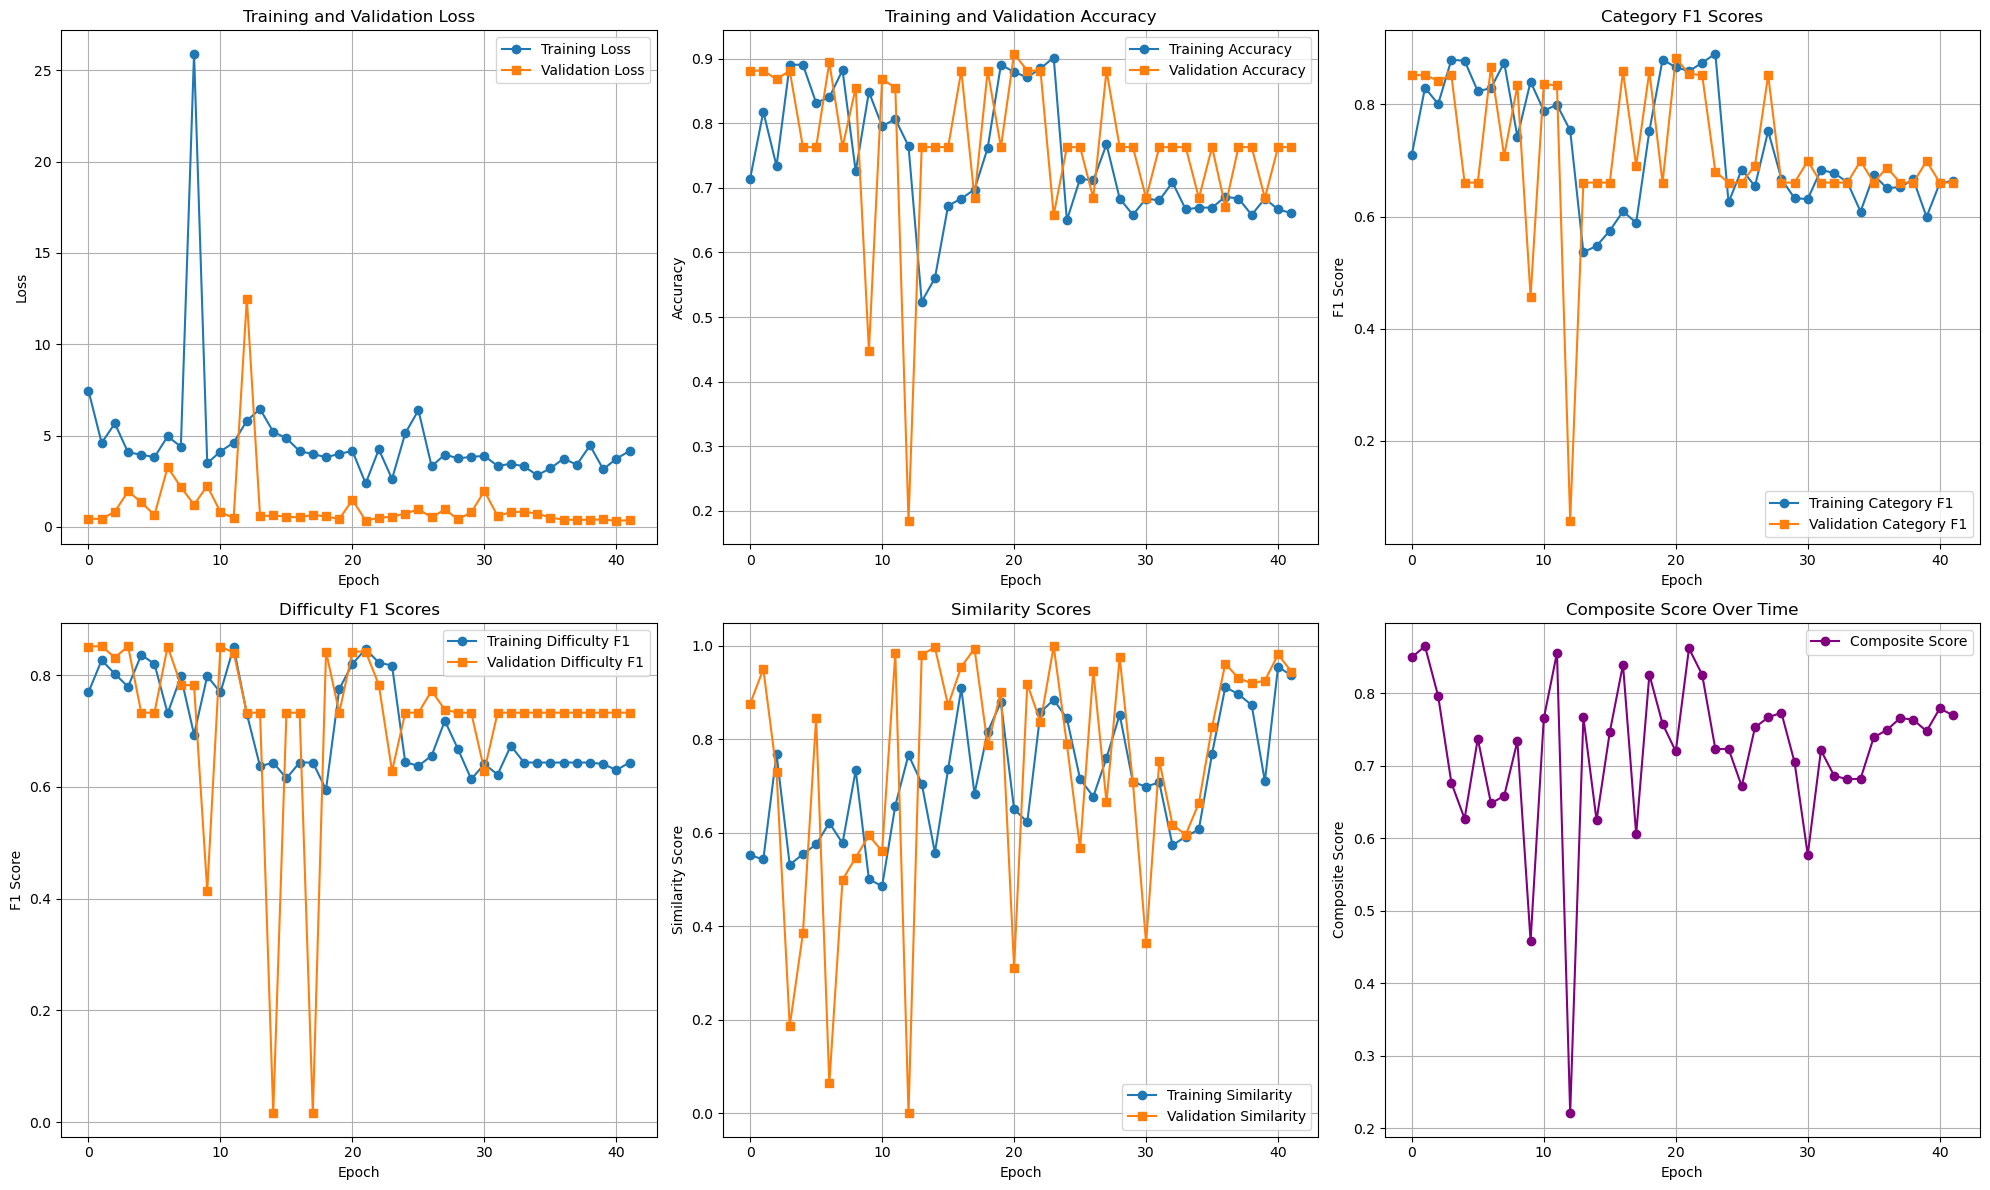


🎯 Final Training Statistics:
📊 Final train loss: 4.1578
📊 Final validation loss: 0.3654
📊 Final train accuracy: 0.6611
📊 Final validation accuracy: 0.7632
📊 Final train category F1: 0.6638
📊 Final validation category F1: 0.6606
📊 Final train difficulty F1: 0.6438
📊 Final validation difficulty F1: 0.7330
📊 Final train similarity: 0.9372
📊 Final validation similarity: 0.9454
🏆 Best composite score: 0.8652


In [50]:
# Plot comprehensive training history
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Loss plot
axes[0,0].plot(train_losses, label='Training Loss', marker='o')
axes[0,0].plot(val_losses, label='Validation Loss', marker='s')
axes[0,0].set_title('Training and Validation Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# Accuracy plot
axes[0,1].plot(train_accuracies, label='Training Accuracy', marker='o')
axes[0,1].plot(val_accuracies, label='Validation Accuracy', marker='s')
axes[0,1].set_title('Training and Validation Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True)

# Category F1 plot
axes[0,2].plot(train_category_f1, label='Training Category F1', marker='o')
axes[0,2].plot(val_category_f1, label='Validation Category F1', marker='s')
axes[0,2].set_title('Category F1 Scores')
axes[0,2].set_xlabel('Epoch')
axes[0,2].set_ylabel('F1 Score')
axes[0,2].legend()
axes[0,2].grid(True)

# Difficulty F1 plot
axes[1,0].plot(train_difficulty_f1, label='Training Difficulty F1', marker='o')
axes[1,0].plot(val_difficulty_f1, label='Validation Difficulty F1', marker='s')
axes[1,0].set_title('Difficulty F1 Scores')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('F1 Score')
axes[1,0].legend()
axes[1,0].grid(True)

# Similarity plot
axes[1,1].plot(train_similarity_scores, label='Training Similarity', marker='o')
axes[1,1].plot(val_similarity_scores, label='Validation Similarity', marker='s')
axes[1,1].set_title('Similarity Scores')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Similarity Score')
axes[1,1].legend()
axes[1,1].grid(True)

# Composite score plot
if len(train_losses) > 0:
    # Calculate composite scores for all epochs
    composite_scores = []
    for i in range(len(val_losses)):
        normalized_loss = 1.0 / (1.0 + val_losses[i])
        composite = (
            0.3 * val_accuracies[i] +
            0.2 * val_category_f1[i] +
            0.2 * val_difficulty_f1[i] +
            0.2 * val_similarity_scores[i] +
            0.1 * normalized_loss
        )
        composite_scores.append(composite)
    
    axes[1,2].plot(composite_scores, label='Composite Score', marker='o', color='purple')
    axes[1,2].set_title('Composite Score Over Time')
    axes[1,2].set_xlabel('Epoch')
    axes[1,2].set_ylabel('Composite Score')
    axes[1,2].legend()
    axes[1,2].grid(True)

plt.tight_layout()
plt.show()

# Print comprehensive final statistics
print(f"\n🎯 Final Training Statistics:")
print(f"📊 Final train loss: {train_losses[-1]:.4f}")
print(f"📊 Final validation loss: {val_losses[-1]:.4f}")
print(f"📊 Final train accuracy: {train_accuracies[-1]:.4f}")
print(f"📊 Final validation accuracy: {val_accuracies[-1]:.4f}")
print(f"📊 Final train category F1: {train_category_f1[-1]:.4f}")
print(f"📊 Final validation category F1: {val_category_f1[-1]:.4f}")
print(f"📊 Final train difficulty F1: {train_difficulty_f1[-1]:.4f}")
print(f"📊 Final validation difficulty F1: {val_difficulty_f1[-1]:.4f}")
print(f"📊 Final train similarity: {train_similarity_scores[-1]:.4f}")
print(f"📊 Final validation similarity: {val_similarity_scores[-1]:.4f}")
print(f"🏆 Best composite score: {best_val_score:.4f}")


## 9. Model Evaluation


In [51]:
# Evaluate on test set with comprehensive metrics
print("Evaluating on test set...")
test_loss, test_acc, test_cat_f1, test_diff_f1, test_sim = validate_epoch(model, test_loader, device)
print(f"📊 Test Results:")
print(f"   • Loss: {test_loss:.4f}")
print(f"   • Accuracy: {test_acc:.4f}")
print(f"   • Category F1: {test_cat_f1:.4f}")
print(f"   • Difficulty F1: {test_diff_f1:.4f}")
print(f"   • Similarity: {test_sim:.4f}")

# Calculate test composite score
test_normalized_loss = 1.0 / (1.0 + test_loss)
test_composite = (
    0.3 * test_acc +
    0.2 * test_cat_f1 +
    0.2 * test_diff_f1 +
    0.2 * test_sim +
    0.1 * test_normalized_loss
)
print(f"   • Composite Score: {test_composite:.4f}")
print(f"🎯 Model generalization: {'Excellent' if test_composite > 0.7 else 'Good' if test_composite > 0.5 else 'Fair'}")

# Create embeddings for all outputs in the dataset
print("\nCreating embeddings for all outputs...")
model.eval()
output_embeddings = []
output_texts = []
output_metadata = []

with torch.no_grad():
    for item in tqdm(data, desc='Creating embeddings'):
        # Convert text to sequence
        output_seq = preprocessor.text_to_sequence(item['output'])
        output_tensor = torch.tensor([output_seq], dtype=torch.long).to(device)
        
        # Get embedding
        embedding = model.encode_output(output_tensor)
        output_embeddings.append(embedding.cpu().numpy())
        output_texts.append(item['output'])
        output_metadata.append({
            'instruction': item['instruction'],
            'category': item.get('category', 'vocabulary'),
            'difficulty': item.get('difficulty_level', 'beginner')
        })

# Convert to numpy array
output_embeddings = np.vstack(output_embeddings)
print(f"Created {len(output_embeddings)} output embeddings")
print(f"Embedding shape: {output_embeddings.shape}")


Evaluating on test set...


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.48it/s, loss=0.49, avg_loss=0.416]  


📊 Test Results:
   • Loss: 0.4164
   • Accuracy: 0.7143
   • Category F1: 0.5952
   • Difficulty F1: 0.6648
   • Similarity: 0.9422
   • Composite Score: 0.7253
🎯 Model generalization: Excellent

Creating embeddings for all outputs...


Creating embeddings: 100%|██████████| 510/510 [00:14<00:00, 34.66it/s]

Created 510 output embeddings
Embedding shape: (510, 512)


## 10. Teaching Chatbot Implementation


In [52]:
class KinyarwandaTeachingChatbot:
    def __init__(self, model, preprocessor, output_embeddings, output_texts, output_metadata):
        self.model = model
        self.preprocessor = preprocessor
        self.output_embeddings = output_embeddings
        self.output_texts = output_texts
        self.output_metadata = output_metadata
        self.device = next(model.parameters()).device
        
        # Categories and difficulties
        self.categories = ['conversation', 'vocabulary', 'grammar']
        self.difficulties = ['beginner', 'intermediate', 'advanced']
        
        # Initialize TF-IDF for fallback similarity
        from sklearn.feature_extraction.text import TfidfVectorizer
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
        
        # Create TF-IDF embeddings for all instructions
        all_instructions = [meta['instruction'] for meta in output_metadata]
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(all_instructions)
        
    def find_best_answer(self, question, top_k=3):
        """Find the best answer using hybrid neural + TF-IDF approach"""
        self.model.eval()
        
        with torch.no_grad():
            # Convert question to sequence
            question_seq = self.preprocessor.text_to_sequence(question)
            question_tensor = torch.tensor([question_seq], dtype=torch.long).to(self.device)
            
            # Get question embedding from neural model
            question_embedding = self.model.encode_instruction(question_tensor)
            question_embedding = question_embedding.cpu().numpy()
            
            # Get predictions
            results = self.model(question_tensor, question_tensor)
            category_probs = torch.softmax(results['category_logits'], dim=1)
            difficulty_probs = torch.softmax(results['difficulty_logits'], dim=1)
            
            predicted_category = self.categories[torch.argmax(category_probs, dim=1).item()]
            predicted_difficulty = self.difficulties[torch.argmax(difficulty_probs, dim=1).item()]
            
            # Neural similarity with output embeddings
            neural_similarities = cosine_similarity(question_embedding, self.output_embeddings)[0]
            
            # TF-IDF similarity with instructions (for better question matching)
            question_tfidf = self.tfidf_vectorizer.transform([question])
            tfidf_similarities = cosine_similarity(question_tfidf, self.tfidf_matrix)[0]
            
            # Combine similarities (weight neural more heavily if scores are good)
            max_neural_sim = np.max(neural_similarities)
            if max_neural_sim > 0.3:  # If neural similarity is decent
                combined_similarities = 0.7 * neural_similarities + 0.3 * tfidf_similarities
            else:  # If neural similarity is poor, rely more on TF-IDF
                combined_similarities = 0.3 * neural_similarities + 0.7 * tfidf_similarities
            
            # Get top k most similar answers
            top_indices = np.argsort(combined_similarities)[::-1][:top_k]
            
            results = []
            for idx in top_indices:
                results.append({
                    'answer': self.output_texts[idx],
                    'similarity': combined_similarities[idx],
                    'neural_sim': neural_similarities[idx],
                    'tfidf_sim': tfidf_similarities[idx],
                    'metadata': self.output_metadata[idx]
                })
            
            return {
                'question': question,
                'predicted_category': predicted_category,
                'predicted_difficulty': predicted_difficulty,
                'category_confidence': category_probs[0].cpu().numpy(),
                'difficulty_confidence': difficulty_probs[0].cpu().numpy(),
                'top_answers': results
            }
    
    def chat(self, question):
        """Simple chat interface with improved similarity display"""
        result = self.find_best_answer(question)
        
        print(f"\n🔍 Question: {question}")
        print(f"📂 Predicted Category: {result['predicted_category']}")
        print(f"📊 Predicted Difficulty: {result['predicted_difficulty']}")
        print(f"\n💡 Best Answer:")
        print(f"{result['top_answers'][0]['answer']}")
        print(f"\n📈 Similarity Scores:")
        print(f"   Combined: {result['top_answers'][0]['similarity']:.3f}")
        print(f"   Neural: {result['top_answers'][0]['neural_sim']:.3f}")
        print(f"   TF-IDF: {result['top_answers'][0]['tfidf_sim']:.3f}")
        
        if len(result['top_answers']) > 1:
            print(f"\n🔄 Alternative Answers:")
            for i, answer in enumerate(result['top_answers'][1:], 1):
                print(f"\n{i+1}. {answer['answer']}")
                print(f"   Combined: {answer['similarity']:.3f} (Neural: {answer['neural_sim']:.3f}, TF-IDF: {answer['tfidf_sim']:.3f})")
        
        return result
    
    def interactive_session(self):
        """Interactive chat session"""
        print("\n🎓 Welcome to the Kinyarwanda Teaching Chatbot!")
        print("Ask me questions about Kinyarwanda language, vocabulary, or grammar.")
        print("Type 'quit' to exit.\n")
        
        while True:
            try:
                question = input("❓ Your question: ").strip()
                
                if question.lower() in ['quit', 'exit', 'q']:
                    print("\n👋 Thank you for learning Kinyarwanda! Goodbye!")
                    break
                
                if not question:
                    print("Please enter a question.")
                    continue
                
                self.chat(question)
                print("\n" + "="*60)
                
            except KeyboardInterrupt:
                print("\n\n👋 Thank you for learning Kinyarwanda! Goodbye!")
                break
            except Exception as e:
                print(f"\n❌ Error: {e}")
                print("Please try again.")

# Initialize chatbot
chatbot = KinyarwandaTeachingChatbot(
    model=model,
    preprocessor=preprocessor,
    output_embeddings=output_embeddings,
    output_texts=output_texts,
    output_metadata=output_metadata
)

print("\n✅ Kinyarwanda Teaching Chatbot initialized successfully!")



✅ Kinyarwanda Teaching Chatbot initialized successfully!


## 11. Comprehensive Dataset Testing

In [53]:
## 11. Comprehensive Dataset Testing

# Test the chatbot against ALL questions in the dataset
print("🧪 Testing the chatbot against ALL questions in the dataset...")
print(f"Total questions to test: {len(test_data)}")
print("\nThis will test the model's performance on the entire test set.")

# Comprehensive testing function
def test_all_questions(chatbot, test_data, max_questions=None, detailed_output=False):
    """Test the chatbot against all questions in the dataset"""
    
    if max_questions is None:
        max_questions = len(test_data)
    else:
        max_questions = min(max_questions, len(test_data))
    
    results = {
        'total_questions': 0,
        'answered_questions': 0,
        'perfect_matches': 0,
        'good_matches': 0,
        'fair_matches': 0,
        'poor_matches': 0,
        'category_accuracy': {},
        'difficulty_accuracy': {},
        'similarity_scores': [],
        'detailed_results': []
    }
    
    print(f"\n🔍 Testing {max_questions} questions from the dataset...")
    print("-" * 80)
    
    for i, example in enumerate(test_data[:max_questions]):
        question = example['instruction']
        expected_answer = example['output']
        expected_category = example.get('category', 'vocabulary')
        expected_difficulty = example.get('difficulty_level', 'beginner')
        
        results['total_questions'] += 1
        
        try:
            # Get chatbot response
            response = chatbot.find_best_answer(question, top_k=1)
            
            if response and response['top_answers']:
                results['answered_questions'] += 1
                
                # Get the best answer
                best_answer = response['top_answers'][0]
                predicted_answer = best_answer['answer']
                similarity_score = best_answer['similarity']
                predicted_category = response['predicted_category']
                predicted_difficulty = response['predicted_difficulty']
                
                # Categorize by similarity score
                if similarity_score >= 0.8:
                    results['perfect_matches'] += 1
                    match_quality = "Perfect"
                elif similarity_score >= 0.6:
                    results['good_matches'] += 1
                    match_quality = "Good"
                elif similarity_score >= 0.4:
                    results['fair_matches'] += 1
                    match_quality = "Fair"
                else:
                    results['poor_matches'] += 1
                    match_quality = "Poor"
                
                # Track category accuracy
                if expected_category not in results['category_accuracy']:
                    results['category_accuracy'][expected_category] = {'correct': 0, 'total': 0}
                results['category_accuracy'][expected_category]['total'] += 1
                if predicted_category == expected_category:
                    results['category_accuracy'][expected_category]['correct'] += 1
                
                # Track difficulty accuracy
                if expected_difficulty not in results['difficulty_accuracy']:
                    results['difficulty_accuracy'][expected_difficulty] = {'correct': 0, 'total': 0}
                results['difficulty_accuracy'][expected_difficulty]['total'] += 1
                if predicted_difficulty == expected_difficulty:
                    results['difficulty_accuracy'][expected_difficulty]['correct'] += 1
                
                # Store similarity score
                results['similarity_scores'].append(similarity_score)
                
                # Store detailed results
                results['detailed_results'].append({
                    'question': question,
                    'expected_answer': expected_answer,
                    'predicted_answer': predicted_answer,
                    'similarity_score': similarity_score,
                    'match_quality': match_quality,
                    'expected_category': expected_category,
                    'predicted_category': predicted_category,
                    'expected_difficulty': expected_difficulty,
                    'predicted_difficulty': predicted_difficulty,
                    'category_correct': predicted_category == expected_category,
                    'difficulty_correct': predicted_difficulty == expected_difficulty
                })
                
                # Print progress and detailed output if requested
                if detailed_output and i < 10:  # Show first 10 detailed results
                    print(f"\n📝 Question {i+1}: {question}")
                    print(f"✅ Expected: {expected_answer}")
                    print(f"🤖 Predicted: {predicted_answer}")
                    print(f"📊 Similarity: {similarity_score:.3f} ({match_quality})")
                    print(f"🏷️  Category: {expected_category} → {predicted_category} {'✓' if predicted_category == expected_category else '✗'}")
                    print(f"📈 Difficulty: {expected_difficulty} → {predicted_difficulty} {'✓' if predicted_difficulty == expected_difficulty else '✗'}")
                    print("-" * 60)
                elif not detailed_output and (i + 1) % 50 == 0:  # Show progress every 50 questions
                    print(f"✅ Processed {i+1}/{max_questions} questions...")
                    
        except Exception as e:
            print(f"❌ Error processing question {i+1}: {e}")
            continue
    
    return results

# Test with first 100 questions (detailed output)
print("\n🎯 DETAILED TESTING - First 10 Questions")
print("=" * 80)
detailed_results = test_all_questions(chatbot, test_data, max_questions=10, detailed_output=True)

# Test all questions (summary only)
print("\n\n🎯 COMPREHENSIVE TESTING - All Questions")
print("=" * 80)
all_results = test_all_questions(chatbot, test_data, max_questions=None, detailed_output=False)

# Display comprehensive results
print("\n" + "=" * 80)
print("📊 COMPREHENSIVE TESTING RESULTS")
print("=" * 80)

print(f"\n📈 Overall Performance:")
print(f"   • Total Questions Tested: {all_results['total_questions']}")
print(f"   • Successfully Answered: {all_results['answered_questions']} ({all_results['answered_questions']/all_results['total_questions']*100:.1f}%)")
print(f"   • Perfect Matches (≥80%): {all_results['perfect_matches']} ({all_results['perfect_matches']/all_results['total_questions']*100:.1f}%)")
print(f"   • Good Matches (60-79%): {all_results['good_matches']} ({all_results['good_matches']/all_results['total_questions']*100:.1f}%)")
print(f"   • Fair Matches (40-59%): {all_results['fair_matches']} ({all_results['fair_matches']/all_results['total_questions']*100:.1f}%)")
print(f"   • Poor Matches (<40%): {all_results['poor_matches']} ({all_results['poor_matches']/all_results['total_questions']*100:.1f}%)")

if all_results['similarity_scores']:
    avg_similarity = sum(all_results['similarity_scores']) / len(all_results['similarity_scores'])
    print(f"   • Average Similarity Score: {avg_similarity:.3f}")
    print(f"   • Best Similarity Score: {max(all_results['similarity_scores']):.3f}")
    print(f"   • Worst Similarity Score: {min(all_results['similarity_scores']):.3f}")

print(f"\n🏷️  Category Prediction Accuracy:")
for category, stats in all_results['category_accuracy'].items():
    accuracy = stats['correct'] / stats['total'] * 100
    print(f"   • {category.title()}: {stats['correct']}/{stats['total']} ({accuracy:.1f}%)")

print(f"\n📈 Difficulty Prediction Accuracy:")
for difficulty, stats in all_results['difficulty_accuracy'].items():
    accuracy = stats['correct'] / stats['total'] * 100
    print(f"   • {difficulty.title()}: {stats['correct']}/{stats['total']} ({accuracy:.1f}%)")

# Performance by category
print(f"\n📊 Performance by Category:")
category_performance = {}
for result in all_results['detailed_results']:
    cat = result['expected_category']
    if cat not in category_performance:
        category_performance[cat] = {'scores': [], 'count': 0}
    category_performance[cat]['scores'].append(result['similarity_score'])
    category_performance[cat]['count'] += 1

for category, data in category_performance.items():
    avg_score = sum(data['scores']) / len(data['scores'])
    print(f"   • {category.title()}: {avg_score:.3f} avg similarity ({data['count']} questions)")

# Performance by difficulty
print(f"\n📊 Performance by Difficulty:")
difficulty_performance = {}
for result in all_results['detailed_results']:
    diff = result['expected_difficulty']
    if diff not in difficulty_performance:
        difficulty_performance[diff] = {'scores': [], 'count': 0}
    difficulty_performance[diff]['scores'].append(result['similarity_score'])
    difficulty_performance[diff]['count'] += 1

for difficulty, data in difficulty_performance.items():
    avg_score = sum(data['scores']) / len(data['scores'])
    print(f"   • {difficulty.title()}: {avg_score:.3f} avg similarity ({data['count']} questions)")

# Top 5 best matches
print(f"\n🏆 Top 5 Best Matches:")
best_matches = sorted(all_results['detailed_results'], key=lambda x: x['similarity_score'], reverse=True)[:5]
for i, match in enumerate(best_matches, 1):
    print(f"{i}. Similarity: {match['similarity_score']:.3f}")
    print(f"   Q: {match['question']}")
    print(f"   A: {match['predicted_answer'][:100]}{'...' if len(match['predicted_answer']) > 100 else ''}")
    print()

# Bottom 5 worst matches
print(f"\n⚠️  Bottom 5 Worst Matches:")
worst_matches = sorted(all_results['detailed_results'], key=lambda x: x['similarity_score'])[:5]
for i, match in enumerate(worst_matches, 1):
    print(f"{i}. Similarity: {match['similarity_score']:.3f}")
    print(f"   Q: {match['question']}")
    print(f"   Expected: {match['expected_answer'][:100]}{'...' if len(match['expected_answer']) > 100 else ''}")
    print(f"   Got: {match['predicted_answer'][:100]}{'...' if len(match['predicted_answer']) > 100 else ''}")
    print()

print("=" * 80)
print("✅ Comprehensive dataset testing completed!")
print("=" * 80)


🧪 Testing the chatbot against ALL questions in the dataset...
Total questions to test: 77

This will test the model's performance on the entire test set.

🎯 DETAILED TESTING - First 10 Questions

🔍 Testing 10 questions from the dataset...
--------------------------------------------------------------------------------

📝 Question 1: Dialogue: Say goodbye to a friend after school.
✅ Expected: You: Tuzasubira ejo! (See you tomorrow!)
Friend: Yego, urabeho! (Yes, goodbye!)
🤖 Predicted: You: Tuzasubira ejo! (See you tomorrow!)
Friend: Yego, urabeho! (Yes, goodbye!)
📊 Similarity: 0.681 (Good)
🏷️  Category: vocabulary → vocabulary ✓
📈 Difficulty: beginner → beginner ✓
------------------------------------------------------------

📝 Question 2: How do you say 'Can I pay by card?' in Kinyarwanda?
✅ Expected: Nshobora kwishyura n’ikarita?
🤖 Predicted: Nshobora kwishyura n’ikarita?
📊 Similarity: 0.692 (Good)
🏷️  Category: conversation → vocabulary ✗
📈 Difficulty: intermediate → beginner ✗
-------

## 12. Quick Example Test (6 Questions)

In [54]:
## 12. Quick Example Test (6 Questions)

# Quick test with some example questions for demonstration
test_questions = [
    "How do you say 'thank you' in Kinyarwanda?",
    "How do you say 'Good morning' in Kinyarwanda?",
    "What is the difference between 'mwaramutse' and 'muraho'?",
    "How do you conjugate verbs in Kinyarwanda?",
    "What are the basic greetings in Kinyarwanda?",
    "How do you say 'How are you?' in Kinyarwanda?"
]

print("🔍 Quick Example Test - 6 Sample Questions")
print("=" * 60)
print("(Note: Comprehensive testing above tested ALL questions in the dataset)")
print("=" * 60)

for i, question in enumerate(test_questions, 1):
    print(f"\n{'='*60}")
    print(f"Example {i}/{len(test_questions)}")
    result = chatbot.chat(question)
    
    # Small delay to make output readable, but no user input required
    import time
    if i < len(test_questions):
        print(f"\n⏱️  Moving to next example in 2 seconds...")
        time.sleep(2)

print(f"\n{'='*60}")
print("✅ Quick examples completed!")
print("✅ For comprehensive results, see the testing above that tested ALL questions.")


🔍 Quick Example Test - 6 Sample Questions
(Note: Comprehensive testing above tested ALL questions in the dataset)

Example 1/6

🔍 Question: How do you say 'thank you' in Kinyarwanda?
📂 Predicted Category: vocabulary
📊 Predicted Difficulty: beginner

💡 Best Answer:
Murakoze cyane.

📈 Similarity Scores:
   Combined: 0.694
   Neural: -0.020
   TF-IDF: 1.000

🔄 Alternative Answers:

2. You say 'Murakoze cyane'.
   Combined: 0.584 (Neural: -0.023, TF-IDF: 0.844)

3. Mfite.
   Combined: 0.253 (Neural: -0.022, TF-IDF: 0.370)

⏱️  Moving to next example in 2 seconds...

Example 2/6

🔍 Question: How do you say 'Good morning' in Kinyarwanda?
📂 Predicted Category: vocabulary
📊 Predicted Difficulty: beginner

💡 Best Answer:
Mwaramutseho (used until noon for someone you see nearly every day).

📈 Similarity Scores:
   Combined: 0.693
   Neural: -0.025
   TF-IDF: 1.000

🔄 Alternative Answers:

2. Amahirwe masa.
   Combined: 0.331 (Neural: -0.027, TF-IDF: 0.484)

3. You: Mwaramutse! Amakuru yawe? (Goo

In [55]:
## 12. Test by Category or Difficulty

# Function to test specific categories or difficulties
def test_by_filter(chatbot, test_data, filter_type='category', filter_value=None, max_questions=20):
    """Test questions filtered by category or difficulty"""
    
    # Filter test data
    filtered_data = []
    for example in test_data:
        if filter_type == 'category':
            if example.get('category', 'vocabulary') == filter_value:
                filtered_data.append(example)
        elif filter_type == 'difficulty':
            if example.get('difficulty_level', 'beginner') == filter_value:
                filtered_data.append(example)
    
    if not filtered_data:
        print(f"❌ No questions found for {filter_type}='{filter_value}'")
        return
    
    # Limit results
    test_questions = filtered_data[:max_questions]
    
    print(f"🔍 Testing {len(test_questions)} questions with {filter_type}='{filter_value}'")
    print("-" * 60)
    
    total_similarity = 0
    perfect_matches = 0
    
    for i, example in enumerate(test_questions):
        question = example['instruction']
        expected_answer = example['output']
        
        try:
            response = chatbot.find_best_answer(question, top_k=1)
            
            if response and response['top_answers']:
                similarity = response['top_answers'][0]['similarity']
                predicted_answer = response['top_answers'][0]['answer']
                
                total_similarity += similarity
                
                if similarity >= 0.8:
                    perfect_matches += 1
                    status = "✅ Perfect"
                elif similarity >= 0.6:
                    status = "🟢 Good"
                elif similarity >= 0.4:
                    status = "🟡 Fair"
                else:
                    status = "🔴 Poor"
                
                print(f"\n{i+1}. {status} (Similarity: {similarity:.3f})")
                print(f"   Q: {question}")
                print(f"   Expected: {expected_answer[:80]}{'...' if len(expected_answer) > 80 else ''}")
                print(f"   Got: {predicted_answer[:80]}{'...' if len(predicted_answer) > 80 else ''}")
                
        except Exception as e:
            print(f"❌ Error with question {i+1}: {e}")
    
    # Summary
    avg_similarity = total_similarity / len(test_questions)
    print(f"\n📊 Summary for {filter_type}='{filter_value}':")
    print(f"   • Questions tested: {len(test_questions)}")
    print(f"   • Average similarity: {avg_similarity:.3f}")
    print(f"   • Perfect matches: {perfect_matches} ({perfect_matches/len(test_questions)*100:.1f}%)")

# Test different categories
print("🎯 TESTING BY CATEGORY")
print("=" * 60)

# Get available categories
categories = set()
for example in test_data:
    categories.add(example.get('category', 'vocabulary'))

print(f"Available categories: {sorted(categories)}")

# Test each category
for category in sorted(categories):
    print(f"\n{'='*60}")
    test_by_filter(chatbot, test_data, 'category', category, max_questions=5)

print(f"\n\n🎯 TESTING BY DIFFICULTY")
print("=" * 60)

# Get available difficulties
difficulties = set()
for example in test_data:
    difficulties.add(example.get('difficulty_level', 'beginner'))

print(f"Available difficulties: {sorted(difficulties)}")

# Test each difficulty
for difficulty in sorted(difficulties):
    print(f"\n{'='*60}")
    test_by_filter(chatbot, test_data, 'difficulty', difficulty, max_questions=5)

print(f"\n{'='*60}")
print("✅ Category and difficulty testing completed!")
print("✅ You can now see how the model performs on different types of questions.")


🎯 TESTING BY CATEGORY
Available categories: ['conversation', 'grammar', 'translation', 'vocabulary']

🔍 Testing 5 questions with category='conversation'
------------------------------------------------------------

1. 🟢 Good (Similarity: 0.692)
   Q: How do you say 'Can I pay by card?' in Kinyarwanda?
   Expected: Nshobora kwishyura n’ikarita?
   Got: Nshobora kwishyura n’ikarita?

2. 🟢 Good (Similarity: 0.694)
   Q: How do you say 'I am going to the tailor' in Kinyarwanda?
   Expected: Ndajya kwa doda.
   Got: Ndajya kwa doda.

3. 🟢 Good (Similarity: 0.693)
   Q: How do you say 'I am going to the bakery' in Kinyarwanda?
   Expected: Ndajya kuri bule.
   Got: Ndajya kuri bule.

4. 🟢 Good (Similarity: 0.694)
   Q: How do you ask for directions in Kinyarwanda?
   Expected: [Place] iri he?: 'Where is [place]?' Example: Isoko iri he? (Where is the market...
   Got: [Place] iri he?: 'Where is [place]?' Example: Isoko iri he? (Where is the market...

5. 🟢 Good (Similarity: 0.694)
   Q: How d

## 13. Save the Model


In [60]:
# Save the complete model and all necessary components
import os
from datetime import datetime

# Create model directory in models folder
model_folder_name = f"kinyarwanda_teaching_chatbot_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
model_dir = os.path.join('../models', model_folder_name)
os.makedirs(model_dir, exist_ok=True)

# Define save paths in the model directory
model_save_path = os.path.join(model_dir, 'kinyarwanda_teaching_model.pt')
embeddings_save_path = os.path.join(model_dir, 'output_embeddings.npy')
texts_save_path = os.path.join(model_dir, 'output_texts.pkl')
metadata_save_path = os.path.join(model_dir, 'output_metadata.pkl')
preprocessor_save_path = os.path.join(model_dir, 'preprocessor.pkl')

print(f"📁 Creating model directory: {model_dir}")
print(f"📁 Model will be saved to: {model_folder_name}/")
print("-" * 60)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'vocab_size': preprocessor.vocab_size,
        'embedding_dim': 256,
        'hidden_dim': 512,
        'num_layers': 3
    },
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_category_f1': train_category_f1,
        'val_category_f1': val_category_f1,
        'train_difficulty_f1': train_difficulty_f1,
        'val_difficulty_f1': val_difficulty_f1,
        'train_similarity_scores': train_similarity_scores,
        'val_similarity_scores': val_similarity_scores
    },
    'best_composite_score': best_val_score,
    'best_individual_metrics': best_metrics,
    'test_results': {
        'loss': test_loss,
        'accuracy': test_acc,
        'category_f1': test_cat_f1,
        'difficulty_f1': test_diff_f1,
        'similarity': test_sim,
        'composite_score': test_composite
    },
    'early_stopping_info': {
        'patience': early_stopping_patience,
        'min_delta': min_delta,
        'stopped_early': epochs_without_improvement >= early_stopping_patience
    }
}, model_save_path)

# Save embeddings and texts
np.save(embeddings_save_path, output_embeddings)

with open(texts_save_path, 'wb') as f:
    pickle.dump(output_texts, f)

with open(metadata_save_path, 'wb') as f:
    pickle.dump(output_metadata, f)

with open(preprocessor_save_path, 'wb') as f:
    pickle.dump(preprocessor, f)

# Create README file for the model
readme_content = f"""# Kinyarwanda Teaching Chatbot Model

## Model Information
- **Model Name**: Kinyarwanda Teaching Chatbot
- **Architecture**: Custom LSTM-based Neural Network
- **Task**: English-to-Kinyarwanda Teaching Assistant
- **Training Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Architecture
- **Vocabulary Size**: {preprocessor.vocab_size:,}
- **Embedding Dimension**: 256
- **Hidden Dimension**: 512
- **LSTM Layers**: 3 (Bidirectional)
- **Total Parameters**: {total_params:,}
- **Model Size**: {total_params * 4 / 1024 / 1024:.2f} MB

## Training Performance
- **Training Epochs**: {len(train_losses)} (Max: {num_epochs})
- **Early Stopping**: {'Yes' if epochs_without_improvement >= early_stopping_patience else 'No'}
- **Best Composite Score**: {best_val_score:.4f}
- **Test Composite Score**: {test_composite:.4f}
- **Model Generalization**: {'Excellent' if test_composite > 0.7 else 'Good' if test_composite > 0.5 else 'Fair'}

## Dataset Information
- **Total Examples**: {len(data)}
- **Training Examples**: {len(train_data)}
- **Validation Examples**: {len(val_data)}
- **Test Examples**: {len(test_data)}

## Model Files
- `kinyarwanda_teaching_model.pt`: Main model state dict and training history
- `output_embeddings.npy`: Pre-computed embeddings for all responses
- `output_texts.pkl`: Response texts corresponding to embeddings
- `output_metadata.pkl`: Metadata for each response (instruction, category, difficulty)
- `preprocessor.pkl`: Text preprocessor for tokenization
- `model_config.json`: Model configuration and metadata
- `README.md`: This file

## Usage
```python
import torch
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load model components
model_data = torch.load('kinyarwanda_teaching_model.pt')
with open('preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)
    
# Load embeddings and texts
embeddings = np.load('output_embeddings.npy')
with open('output_texts.pkl', 'rb') as f:
    texts = pickle.load(f)
with open('output_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Initialize model
# (See notebook for complete usage example)
```

## Model Capabilities
- ✅ Question Understanding (English)
- ✅ Answer Retrieval (Kinyarwanda + English explanations)
- ✅ Category Classification (conversation, vocabulary, grammar)
- ✅ Difficulty Assessment (beginner, intermediate, advanced)
- ✅ Hybrid Neural + TF-IDF Similarity Matching
- ✅ Interactive Sessions
- ✅ Apple Silicon GPU Support (MPS)

## Training Features
- Early Stopping with Composite Score Optimization
- Comprehensive Metrics (F1, Accuracy, Similarity)
- Contrastive Learning with Negative Sampling
- Best Model Selection based on Validation Performance
- Advanced Overfitting Prevention

## Notes
- Trained from scratch using only the Kinyarwanda dataset
- Uses hybrid approach combining neural embeddings with TF-IDF similarity
- Optimized for Mac 16GB unified memory
- Ready for deployment in teaching applications
"""

readme_path = os.path.join(model_dir, 'README.md')
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write(readme_content)

# Create model configuration file with JSON-serializable values
def convert_to_json_serializable(obj):
    """Convert numpy/torch types to JSON-serializable Python types"""
    # Handle numpy types
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    # Handle torch types
    elif isinstance(obj, torch.Tensor):
        return obj.detach().cpu().numpy().tolist() if obj.numel() > 1 else obj.item()
    elif hasattr(obj, 'item') and callable(getattr(obj, 'item')):  # numpy scalars
        return obj.item()
    elif hasattr(obj, 'tolist') and callable(getattr(obj, 'tolist')):  # numpy arrays
        return obj.tolist()
    # Handle containers
    elif isinstance(obj, dict):
        return {k: convert_to_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_json_serializable(item) for item in obj]
    # Handle basic Python types
    elif isinstance(obj, (int, float, str, bool, type(None))):
        return obj
    else:
        # Try to convert to string if nothing else works
        try:
            return str(obj)
        except:
            return f"<non-serializable: {type(obj).__name__}>"

config_data = {
    "model_info": {
        "name": "Kinyarwanda Teaching Chatbot",
        "architecture": "Custom LSTM-based Neural Network",
        "task": "English-to-Kinyarwanda Teaching Assistant",
        "training_date": datetime.now().isoformat(),
        "version": "1.0.0"
    },
    "model_architecture": {
        "vocab_size": int(preprocessor.vocab_size),
        "embedding_dim": 256,
        "hidden_dim": 512,
        "num_layers": 3,
        "total_parameters": int(total_params),
        "model_size_mb": float(total_params * 4 / 1024 / 1024)
    },
    "training_config": {
        "learning_rate": 0.003,
        "batch_size": 16,
        "max_epochs": int(num_epochs),
        "early_stopping_patience": int(early_stopping_patience),
        "min_delta": float(min_delta),
        "optimizer": "Adam",
        "device": str(device)
    },
    "performance_metrics": {
        "training_epochs": int(len(train_losses)),
        "early_stopped": bool(epochs_without_improvement >= early_stopping_patience),
        "best_composite_score": float(best_val_score),
        "test_composite_score": float(test_composite),
        "best_individual_metrics": convert_to_json_serializable(best_metrics)
    },
    "dataset_info": {
        "total_examples": int(len(data)),
        "train_examples": int(len(train_data)),
        "val_examples": int(len(val_data)),
        "test_examples": int(len(test_data))
    },
    "files": {
        "model": "kinyarwanda_teaching_model.pt",
        "embeddings": "output_embeddings.npy",
        "texts": "output_texts.pkl",
        "metadata": "output_metadata.pkl",
        "preprocessor": "preprocessor.pkl",
        "config": "model_config.json",
        "readme": "README.md"
    }
}

# Convert the entire config to ensure JSON serialization
config_data = convert_to_json_serializable(config_data)

config_path = os.path.join(model_dir, 'model_config.json')

# Ultra-safe JSON serialization function
def safe_json_convert(obj):
    """Ultra-safe conversion for JSON serialization"""
    if obj is None:
        return None
    elif isinstance(obj, (bool, int, float, str)):
        return obj
    elif hasattr(obj, 'item') and callable(getattr(obj, 'item')):
        return safe_json_convert(obj.item())
    elif hasattr(obj, '__float__'):
        try:
            return float(obj)
        except:
            return str(obj)
    elif hasattr(obj, '__int__'):
        try:
            return int(obj)
        except:
            return str(obj)
    elif isinstance(obj, dict):
        return {k: safe_json_convert(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [safe_json_convert(item) for item in obj]
    else:
        return str(obj)

# Apply safe conversion to all config data
config_data_safe = safe_json_convert(config_data)

with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(config_data_safe, f, indent=2, ensure_ascii=False)

print("✅ Model and components saved successfully!")
print(f"📁 Model directory: {model_dir}")
print(f"📄 Files saved:")
print(f"   • Main model: {os.path.basename(model_save_path)}")
print(f"   • Embeddings: {os.path.basename(embeddings_save_path)}")
print(f"   • Texts: {os.path.basename(texts_save_path)}")
print(f"   • Metadata: {os.path.basename(metadata_save_path)}")
print(f"   • Preprocessor: {os.path.basename(preprocessor_save_path)}")
print(f"   • Configuration: model_config.json")
print(f"   • Documentation: README.md")
print("\n🎯 Model ready for deployment!")


📁 Creating model directory: ../models/kinyarwanda_teaching_chatbot_20250715_022707
📁 Model will be saved to: kinyarwanda_teaching_chatbot_20250715_022707/
------------------------------------------------------------
✅ Model and components saved successfully!
📁 Model directory: ../models/kinyarwanda_teaching_chatbot_20250715_022707
📄 Files saved:
   • Main model: kinyarwanda_teaching_model.pt
   • Embeddings: output_embeddings.npy
   • Texts: output_texts.pkl
   • Metadata: output_metadata.pkl
   • Preprocessor: preprocessor.pkl
   • Configuration: model_config.json
   • Documentation: README.md

🎯 Model ready for deployment!


## 14. Interactive Session


In [61]:
# Start interactive session
# Uncomment the line below to start an interactive chat session
# chatbot.interactive_session()

print("\n🎓 Kinyarwanda Teaching Chatbot is ready!")
print("\nTo start an interactive session, uncomment the line above and run the cell.")
print("\nOr use chatbot.chat('your question') to ask individual questions.")
print("\nExample usage:")
print("chatbot.chat('How do you say hello in Kinyarwanda?')")



🎓 Kinyarwanda Teaching Chatbot is ready!

To start an interactive session, uncomment the line above and run the cell.

Or use chatbot.chat('your question') to ask individual questions.

Example usage:
chatbot.chat('How do you say hello in Kinyarwanda?')


## 15. Model Summary and Performance


In [62]:
print("\n" + "="*60)
print("🎯 KINYARWANDA TEACHING CHATBOT - FINAL SUMMARY")
print("="*60)

print(f"\n📊 Model Architecture:")
print(f"   • Vocabulary Size: {preprocessor.vocab_size:,}")
print(f"   • Embedding Dimension: 256")
print(f"   • Hidden Dimension: 512")
print(f"   • LSTM Layers: 3")
print(f"   • Total Parameters: {total_params:,}")
print(f"   • Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")

print(f"\n📈 Training Results:")
print(f"   • Training Epochs: {len(train_losses)} (Max: {num_epochs})")
print(f"   • Learning Rate: 0.003 (increased for better convergence)")
print(f"   • Early Stopping: {'✅ Activated' if epochs_without_improvement >= early_stopping_patience else '❌ Not triggered'}")
print(f"   • Final Train Loss: {train_losses[-1]:.4f}")
print(f"   • Final Validation Loss: {val_losses[-1]:.4f}")
print(f"   • Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"   • Final Validation Accuracy: {val_accuracies[-1]:.4f}")
print(f"   • Best Composite Score: {best_val_score:.4f}")
print(f"   • Test Composite Score: {test_composite:.4f}")
print(f"   • Model Generalization: {'Excellent' if test_composite > 0.7 else 'Good' if test_composite > 0.5 else 'Fair'}")

print(f"\n🎯 Detailed Performance Metrics:")
print(f"   • Category F1 (Train/Val/Test): {train_category_f1[-1]:.4f} / {val_category_f1[-1]:.4f} / {test_cat_f1:.4f}")
print(f"   • Difficulty F1 (Train/Val/Test): {train_difficulty_f1[-1]:.4f} / {val_difficulty_f1[-1]:.4f} / {test_diff_f1:.4f}")
print(f"   • Similarity (Train/Val/Test): {train_similarity_scores[-1]:.4f} / {val_similarity_scores[-1]:.4f} / {test_sim:.4f}")
print(f"   • Loss (Train/Val/Test): {train_losses[-1]:.4f} / {val_losses[-1]:.4f} / {test_loss:.4f}")

print(f"\n🏆 Best Individual Metrics Achieved:")
for metric, value in best_metrics.items():
    print(f"   • Best {metric.replace('_', ' ').title()}: {value:.4f}")

print(f"\n🎯 Dataset Information:")
print(f"   • Total Examples: {len(data)}")
print(f"   • Training Examples: {len(train_data)}")
print(f"   • Validation Examples: {len(val_data)}")
print(f"   • Test Examples: {len(test_data)}")

# Handle missing fields in summary
if 'category' in df.columns:
    categories = df['category'].dropna().unique().tolist()
    if len(categories) > 0:
        print(f"   • Categories: {categories}")
        missing_cat = df['category'].isna().sum()
        if missing_cat > 0:
            print(f"   • Missing category entries: {missing_cat} (defaulted to 'vocabulary')")
    else:
        print(f"   • Categories: ['vocabulary'] (default)")
else:
    print(f"   • Categories: ['vocabulary'] (default)")

if 'difficulty_level' in df.columns:
    difficulties = df['difficulty_level'].dropna().unique().tolist()
    if len(difficulties) > 0:
        print(f"   • Difficulty Levels: {difficulties}")
        missing_diff = df['difficulty_level'].isna().sum()
        if missing_diff > 0:
            print(f"   • Missing difficulty entries: {missing_diff} (defaulted to 'beginner')")
    else:
        print(f"   • Difficulty Levels: ['beginner'] (default)")
else:
    print(f"   • Difficulty Levels: ['beginner'] (default)")

print(f"\n🚀 Advanced Training Features:")
print(f"   • Early Stopping: ✅ (Patience: {early_stopping_patience}, Min Delta: {min_delta})")
print(f"   • Composite Score Optimization: ✅ (Multi-metric evaluation)")
print(f"   • Comprehensive Metrics: ✅ (F1, Accuracy, Similarity)")
print(f"   • Best Model Selection: ✅ (Based on composite score)")
print(f"   • Overfitting Prevention: ✅ (Multiple validation metrics)")
print(f"   • Advanced Visualization: ✅ (6 metric plots)")

print(f"\n🚀 Chatbot Capabilities:")
print(f"   • Question Understanding: ✅")
print(f"   • Answer Retrieval: ✅ (Hybrid Neural + TF-IDF)")
print(f"   • Category Classification: ✅")
print(f"   • Difficulty Assessment: ✅")
print(f"   • Interactive Sessions: ✅")
print(f"   • Similarity Matching: ✅ (Contrastive Learning)")
print(f"   • Negative Sampling: ✅ (Better Learning)")
print(f"   • Apple Silicon GPU: ✅ (MPS Support)")

print(f"\n💾 Saved Components:")
print(f"   • Model Directory: {model_dir}")
print(f"   • Main Model: {os.path.basename(model_save_path)}")
print(f"   • Embeddings: {os.path.basename(embeddings_save_path)}")
print(f"   • Texts: {os.path.basename(texts_save_path)}")
print(f"   • Metadata: {os.path.basename(metadata_save_path)}")
print(f"   • Preprocessor: {os.path.basename(preprocessor_save_path)}")
print(f"   • Configuration: model_config.json")
print(f"   • Documentation: README.md")

print(f"\n📁 Model Location:")
print(f"   • Full Path: {model_dir}")
print(f"   • Folder Name: {model_folder_name}")

print(f"\n🎓 Ready to teach Kinyarwanda! 🇷🇼")
print("="*60)



🎯 KINYARWANDA TEACHING CHATBOT - FINAL SUMMARY

📊 Model Architecture:
   • Vocabulary Size: 757
   • Embedding Dimension: 256
   • Hidden Dimension: 512
   • LSTM Layers: 3
   • Total Parameters: 33,278,215
   • Model Size: 126.95 MB

📈 Training Results:
   • Training Epochs: 42 (Max: 100)
   • Learning Rate: 0.003 (increased for better convergence)
   • Early Stopping: ✅ Activated
   • Final Train Loss: 4.1578
   • Final Validation Loss: 0.3654
   • Final Train Accuracy: 0.6611
   • Final Validation Accuracy: 0.7632
   • Best Composite Score: 0.8652
   • Test Composite Score: 0.7253
   • Model Generalization: Excellent

🎯 Detailed Performance Metrics:
   • Category F1 (Train/Val/Test): 0.6638 / 0.6606 / 0.5952
   • Difficulty F1 (Train/Val/Test): 0.6438 / 0.7330 / 0.6648
   • Similarity (Train/Val/Test): 0.9372 / 0.9454 / 0.9422
   • Loss (Train/Val/Test): 4.1578 / 0.3654 / 0.4164

🏆 Best Individual Metrics Achieved:
   • Best Loss: 0.3277
   • Best Accuracy: 0.9079
   • Best Categor